In [1]:
# import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gc
import traceback
from swifter import swiftapply
import os

In [7]:
%lsmagic # jupyter의 숨겨진 기능들. 

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl  %%prun  %%pypy  %%python  %%python2  %%python3  %%rub

<h3>데이터 불러오기. - 주의. 데이터 매우 큼. 600MB 이상의 csv 파일임.</h3>

In [2]:
df = pd.read_csv("nubija_15-16.csv", sep=',', encoding='EUC-KR')

In [ ]:
chr(0xc0) # utf-8 인코딩은 오류남.

'À'

In [4]:
df.head()

,Unnamed: 0,자전거번호,출발터미널,출발일,출발시간,도착터미널,도착일,도착시간
0,1,5322,180,20150101,0,180,20150101,19
1,2,6844,94,20150101,10,144,20150101,1435
2,3,5475,180,20150101,35,107,20150101,345
3,4,6347,28,20150101,36,121,20150101,91100
4,5,7416,9,20150101,41,60,20150101,1109


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11718608 entries, 0 to 11718607
Data columns (total 8 columns):
Unnamed: 0    int64
자전거번호         int64
출발터미널         int64
출발일           int64
출발시간          int64
도착터미널         int64
도착일           int64
도착시간          int64
dtypes: int64(8)
memory usage: 715.2 MB


<h3>'unnamed: 0' (index) 컬럼 제거하고 column명 영어로 변경</h3>

In [6]:
df = df.drop('Unnamed: 0', axis=1)

In [7]:
col_kor2eng = {"자전거번호":"id", "출발터미널":"dept_terminal", "출발일":"dept_date", "출발시간":"dept_time", "도착터미널":"arr_terminal", "도착일":"arr_date", "도착시간":"arr_time" }

In [8]:
df.rename(columns=col_kor2eng, inplace=True)

<h3>todatetime하기 전에 int64인 날짜, 시간 zero fill하고 str으로 바꿈. </h3>
<h3>bike id와 terminal id도 str으로 바꿔줌.</h3>

In [9]:
print(str(91100).zfill(6))
type(str(91100).zfill(6))

091100


str

In [10]:
df.head()

,id,dept_terminal,dept_date,dept_time,arr_terminal,arr_date,arr_time
0,5322,180,20150101,0,180,20150101,19
1,6844,94,20150101,10,144,20150101,1435
2,5475,180,20150101,35,107,20150101,345
3,6347,28,20150101,36,121,20150101,91100
4,7416,9,20150101,41,60,20150101,1109


In [11]:
df["id"] = df["id"].astype(str)
df["dept_terminal"] = df["dept_terminal"].astype(str)
df["arr_terminal"] = df["arr_terminal"].astype(str)

In [12]:
# HHMMSS를 나타내는 6자리 값이어야 하는데, int면 그냥 0103 이런 식으로 존재하므로 "000103" 이런 형식으로 고쳐줌. 
df["dept_date"] = df["dept_date"].astype(str).apply(lambda x: x.zfill(6))  
df["dept_time"] = df["dept_time"].astype(str).apply(lambda x: x.zfill(6))
df["arr_date"] = df["arr_date"].astype(str).apply(lambda x: x.zfill(6))
df["arr_time"] = df["arr_time"].astype(str).apply(lambda x: x.zfill(6))

In [13]:
df.tail(50)

,id,dept_terminal,dept_date,dept_time,arr_terminal,arr_date,arr_time
11718558,6222,21,20161231,234732,244,20170101,003611
11718559,7880,62,20161231,234817,130,20161231,235412
11718560,6185,140,20161231,234827,182,20161231,235832
11718561,7870,173,20161231,234842,174,20161231,235426
11718562,8445,167,20161231,234906,189,20161231,235220
11718563,5580,56,20161231,234910,40,20170101,000330
11718564,8459,54,20161231,234951,136,20161231,235920
11718565,5362,62,20161231,234952,64,20161231,235909
11718566,7546,155,20161231,234953,42,20161231,235928
11718567,5573,17,20161231,234955,277,20170101,002740


In [14]:
df["dept_time"] = df["dept_date"]+df["dept_time"]
df["arr_time"] = df["arr_date"]+df["arr_time"]

In [15]:
df['dept_time'] = pd.to_datetime(df['dept_time'], format="%Y%m%d%H%M%S", errors = 'ignore')
df['arr_time'] = pd.to_datetime(df['arr_time'], format="%Y%m%d%H%M%S", errors = 'ignore')

In [16]:
df = df.drop(["dept_date", "arr_date"], axis=1)

,id,dept_terminal,dept_time,arr_terminal,arr_time
0,5322,180,2015-01-01 00:00:00,180,2015-01-01 00:00:19
1,6844,94,2015-01-01 00:00:10,144,2015-01-01 00:14:35
2,5475,180,2015-01-01 00:00:35,107,2015-01-01 00:03:45
3,6347,28,2015-01-01 00:00:36,121,2015-01-01 09:11:00
4,7416,9,2015-01-01 00:00:41,60,2015-01-01 00:11:09
5,7282,148,2015-01-01 00:00:47,121,2015-01-01 00:19:10
6,7978,21,2015-01-01 00:00:52,59,2015-01-01 00:16:04
7,6777,28,2015-01-01 00:00:53,155,2015-01-01 00:05:53
8,7389,11,2015-01-01 00:00:55,27,2015-01-01 00:11:14
9,7115,222,2015-01-01 00:01:12,218,2015-01-01 00:10:24


<h3>여기서 잠깐 EDA</h3>

In [28]:
len(df.id.unique()) # 총 자전거의 갯수

3872

In [29]:
len(df.dept_terminal.unique()) # 출발지 터미널 갯수

266

In [30]:
len(df.arr_terminal.unique()) # 도착지 터미널 갯수

267

<h3>usedtime = arr_time - dept_time 변수 생성 (time delta) & 여태까지 한거 저장.(dtype 유지를 위해서 pickle로 저장)</h3>

In [17]:
df["usedtime"] = (df.arr_time - df.dept_time ).astype("timedelta64[ns]")

In [19]:
df.head(100)

,id,dept_terminal,dept_date,dept_time,arr_terminal,arr_date,arr_time,usedtime
0,5322,180,20150101,2015-01-01 00:00:00,180,20150101,2015-01-01 00:00:19,00:00:19
1,6844,94,20150101,2015-01-01 00:00:10,144,20150101,2015-01-01 00:14:35,00:14:25
2,5475,180,20150101,2015-01-01 00:00:35,107,20150101,2015-01-01 00:03:45,00:03:10
3,6347,28,20150101,2015-01-01 00:00:36,121,20150101,2015-01-01 09:11:00,09:10:24
4,7416,9,20150101,2015-01-01 00:00:41,60,20150101,2015-01-01 00:11:09,00:10:28
5,7282,148,20150101,2015-01-01 00:00:47,121,20150101,2015-01-01 00:19:10,00:18:23
6,7978,21,20150101,2015-01-01 00:00:52,59,20150101,2015-01-01 00:16:04,00:15:12
7,6777,28,20150101,2015-01-01 00:00:53,155,20150101,2015-01-01 00:05:53,00:05:00
8,7389,11,20150101,2015-01-01 00:00:55,27,20150101,2015-01-01 00:11:14,00:10:19
9,7115,222,20150101,2015-01-01 00:01:12,218,20150101,2015-01-01 00:10:24,00:09:12


In [20]:
df.to_pickle('nubija_15-16_pickled.p')

In [27]:
gc.collect()

14

<h1 style='color:red'>저장한 파일 불러와서 작업</h1>

<h3>하지만 메모리를 너무 많이 먹어서 오류남. object type column이 주로 메모리를 소비하므로 최적화를 위해 uint16으로 바꿔주고 .pickle로 다시 저장. 그 결과 메모리 소비량이 반 이상 줄음. (아래 블록은 그냥 기록을 위해 남김.) </h3>

In [60]:
df = pd.read_pickle('nubija_15-16_pickled.p')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11718608 entries, 0 to 11718607
Data columns (total 7 columns):
id               uint16
dept_terminal    uint16
dept_time        datetime64[ns]
arr_terminal     uint16
arr_time         datetime64[ns]
usedtime         timedelta64[ns]
usedtime_hour    float64
dtypes: datetime64[ns](2), float64(1), timedelta64[ns](1), uint16(3)
memory usage: 424.7 MB


In [11]:
df["id"] = df["id"].astype('uint16')

In [12]:
df["dept_terminal"] = df["dept_terminal"].astype('uint16')
df["arr_terminal"] = df["arr_terminal"].astype('uint16')

In [14]:
df = df.drop(["dept_date", "arr_date"], axis=1)

In [41]:
df['usedtime_hour'] = df['usedtime'].apply(lambda x: (x.seconds)/3600)

In [42]:
df.to_pickle('nubija_15-16_pickled.p')

<h3>터미널 간 이동 거리 distance 컬럼을 추가하고 & avg_speed = distance / usedtime 컬럼도 추가함. </h3>
<h3>추후 시속을 구하기 위해 usedtime_hour도 생성 (dtype: float)</h3>

distance_dic도 dictionary보다 pandas df가 더 빠를 수 있다는 말이 있으므로 pandas df를 불러들여 해보겠음. 

In [19]:
# with open('distance_dic_pickle.p', 'rb') as fp:
#     distance_dic = pickle.load(fp)

# dictionary로 저장된 pickle 읽어들임. 

<p style='color: red;'>참조할 distance df 불러들인다.</p>

In [62]:
# df로 저장된 pickle 읽어들임. 
distance_df = pd.read_pickle("distance_dic_df.p")

In [5]:
distance_df

,dept_terminal,arr_terminal,distance
0,8,8,0.00
1,8,9,0.85
2,9,8,0.85
3,8,10,1.20
4,10,8,1.20
5,8,11,2.59
6,11,8,2.59
7,8,12,1.28
8,12,8,1.28
9,8,15,4.97


In [2]:
##아래 작업이 너무 많이 걸려서 progress bar를 넣어서 관찰하기로 함. 
## 사용법 간단함. 그냥 log_progress( ) 만 씌우면 됨. 

##### progress bar #####

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [19]:
## distance 를 distance_dic에서 검색해 입력해준다. 

# 이대로 돌리면 분당 700 row정도 처리함. 
# iterrows 는 performance issue가 있다. 특수한 상황에서만 쓰여야 한다. 
# https://stackoverflow.com/questions/24870953/does-iterrows-have-performance-issues

# df['distance'] = 0

# for index, row in log_progress(df.iterrows(), every=10):
    
#     if row['dept_terminal'] == row['arr_terminal']: # 출발지와 도착지가 같을 경우 0으로 나오므로, (이용시간 * 15km/h) 로 imputation 해준다.
#         df.loc[index, 'distance'] = row['usedtime_hour']*15

#         continue
    
#     try: # distance_dic에서 검색될 경우 그 거리를 입력해준다. 
#         df.loc[index, 'distance'] = distance_dic[(min(row['dept_terminal'], row['arr_terminal']), max(row['dept_terminal'], row['arr_terminal']))]

#     except KeyError: # distance_dic에 없을 경우 -1로 바꾸고 추후 없애준다. 
#         df.loc[index, 'distance'] = -1

#         pass
        
#     except Exception as e: # 에러 나면 에러 메세지와 에러난 항목을 print 한다. 
#         traceback.print_exc()
#         print("error: ", e)
#         print(df.loc[index, 'distance'])
#         pass

In [6]:
distance_df.loc[(distance_df.dept == 8) & (distance_df.arr == 9)].distance.values[0]

46.62

In [13]:
distance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34515 entries, 0 to 34514
Data columns (total 3 columns):
dept        34515 non-null int64
arr         34515 non-null int64
distance    34515 non-null float64
dtypes: float64(1), int64(2)
memory usage: 809.0 KB


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11718608 entries, 0 to 11718607
Data columns (total 7 columns):
id               uint16
dept_terminal    uint16
dept_time        datetime64[ns]
arr_terminal     uint16
arr_time         datetime64[ns]
usedtime         timedelta64[ns]
usedtime_hour    float64
dtypes: datetime64[ns](2), float64(1), timedelta64[ns](1), uint16(3)
memory usage: 424.7 MB


In [269]:
# # 이건 결국 안쓴다. 

# def distance_mapper(dept,arr,usedtime_hour, bigger):
    
# #     mini = min(dept,arr)
# #     maxi = max(dept,arr)
#     maxi = x*bigger[0] + y*(~bigger[0])
#     mini = x*(~bigger[0]) + y*(bigger[0])
#     # 아아... apply를 통해 들어온 것들은 series였던 것이다. 그래서 [0]번째를 선택해야 value가 나오는 것이었다. 
#     # 여기서 mini/maxi가 np가 되는 이유는bigger을 곱했기 때문. (bigger이 np.bool이 들어있는 pd.df다. )
#     # 그래서 bigger[0]으로 꺼냈다. 
    
    
#     ### series를 가져와서 series 자체를 한꺼번에 더하는게 vectorized 연산이기 때문에 애초에 이렇게 처리 못한다. 
    
    
# #     print("bigger \n", bigger)
#     print("bigger[0] \n",bigger[0])
#     print("#######")
# #     print("bigger*3 \n", 3*bigger)
#     print("bigger[0]*3 \n",3*bigger[0])
#     print("---")
#     print(maxi[0])
# #     print(mini[0])
#     print("==")
    
#     dist = -1
    
#     if mini[0] == maxi[0]:
#         return 15*usedtime_hour[0] #여기도 마찬가지다. return시 series로 반환해도 제대로 df에 입력되지만, 중간에 연산시 [0]로 하여 value를 불러줘야 한다. 
    
#     try:
#         dist = distance_df.loc[(distance_df.dept == mini[0]) & (distance_df.arr == maxi[0])].distance.values[0]
#     except:    
#         return -1

#     return dist

In [ ]:
# apply는 너무 오래 걸린다. 

# df["distance"] = df.apply(lambda x: distance_mapper(x['dept_terminal'], x['arr_terminal'], x['usedtime_hour']), axis=1)

In [121]:
# bigger 을 판별할 column을 하나 넣어준다. apply할 때 대소비교 할 줄 몰랐어서 이걸 괜히 만들었었다. 
# 기왕에 만들었으니 그냥 쓰도록 한다. 

# 결국 merge 방식을 쓰면서 이것도 안씀. 

# df['bigger']= df.apply(lambda x: (x['dept_terminal'] > x['arr_terminal']), axis=1)

In [245]:
# 대신 swifter package의 swift apply를 적용해보겠다. 자동으로 vectorization을 시도한다. 
# distance를 swift apply를 써서 mapping한다. 

# but... vectorized 연산은 선형 연산이 가능해야 한다. 
# df["distance"] = swiftapply(df["dept_terminal"], distance_mapper, arr=df['arr_terminal'], usedtime_hour=df['usedtime_hour'], bigger=df['bigger'])

E:\Jaepil\PycharmProjects\daa_proj1_02\venv\lib\site-packages\dask\base.py:833: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


In [65]:
df.head()

,id,dept_terminal,dept_time,arr_terminal,arr_time,usedtime,usedtime_hour,distance
0,5322,180,2015-01-01 00:00:00,180,2015-01-01 00:00:19,00:00:19,0.005278,0.00
1,6844,94,2015-01-01 00:00:10,144,2015-01-01 00:14:35,00:14:25,0.240278,2.18
2,5475,180,2015-01-01 00:00:35,107,2015-01-01 00:03:45,00:03:10,0.052778,0.94
3,6347,28,2015-01-01 00:00:36,121,2015-01-01 09:11:00,09:10:24,9.173333,2.81
4,7416,9,2015-01-01 00:00:41,60,2015-01-01 00:11:09,00:10:28,0.174444,0.60


<p style='color: red'>결국 이 merge로 해결했다. </p>

In [64]:
# 결국 이 코드로 해결했다. 

df = pd.merge(df, distance_df, how='left', on=['dept_terminal', 'arr_terminal'])

In [9]:
# merge 로 인해 생겨난 distance_x 컬럼 제거. 

# df = df.drop("distance_x", axis=1)

<h3>bike id에 따라 groupby로 나눈다. 추후 일부 자전거만 sampling해서 분석해야 할지도 모른다.</h3>

In [39]:
# pd groupby 객체다. df아님. 
bikes = df.groupby("id")

In [33]:
bikes.groups

{3198: Int64Index([ 1743,  2577,  4171,  4256,  6055,  9174, 14024, 21083, 21195,
             21373, 22402, 24908, 26663],
            dtype='int64'),
 3396: Int64Index([  2111,   2803,   2805,   7251,   7538,   7539,   8017,  10874,
              11230,  11910,  12085,  14877,  15106,  15203,  15664,  15834,
              15925,  16358,  18340,  19659,  23131,  24165,  27227,  31035,
              31967,  32689,  36976,  50682,  65113,  67352,  76112,  77170,
              87109,  92639,  93706, 102473, 112836, 115928, 118924, 121688,
             122712, 130421, 132030, 134184, 139668, 146068, 147264, 148497,
             160400, 161968, 169291, 174486, 174592, 176868, 178478, 179759,
             180517, 181073, 182503, 185742, 186189, 188775, 191827, 191841,
             211680, 214138, 214892, 220672, 224061, 224862, 227718, 230197,
             240644, 242041, 243970, 244165, 246990],
            dtype='int64'),
 3443: Int64Index([ 61164,  63079,  79519,  79521,  79773,  80927, 

In [40]:
# 여기에 id 순으로 각 자전거의 시계열 df가 들어가 있음. 
# 이게 중요한 변수임. 

bike_groups = [bikes.get_group(x) for x in bikes.groups]

In [12]:
len(bike_groups)

3872

<h3>각 자전거에 대해 dept_terminal과 arr_terminal이 다른 경우를 check 해줌. moved=True인 시점들은 자전거가 옮겨진 시점.</h3>

In [41]:
pd.options.mode.chained_assignment = 'warn'  # default='warn'

In [42]:
# 이 옵션을 설정해줘야 한다. 
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

pd.options.mode.chained_assignment = None  # default='warn'

In [43]:
for d in bike_groups:
    d['moved'] = d.loc[: ,'dept_terminal'] != d.loc[: , 'arr_terminal'].shift(1)

In [16]:
test = bike_groups[1]

In [17]:
test

,id,dept_terminal,dept_time,arr_terminal,arr_time,usedtime,usedtime_hour,distance,moved
2111,3396,42,2015-01-01 13:16:56,42,2015-01-01 13:17:57,00:01:01,0.016944,0.00,True
2803,3396,42,2015-01-01 15:08:48,42,2015-01-01 15:08:53,00:00:05,0.001389,0.00,False
2805,3396,42,2015-01-01 15:08:58,148,2015-01-01 15:22:20,00:13:22,0.222778,1.07,False
7251,3396,148,2015-01-02 09:18:18,42,2015-01-02 09:23:56,00:05:38,0.093889,1.07,False
7538,3396,42,2015-01-02 09:51:25,42,2015-01-02 09:51:30,00:00:05,0.001389,0.00,False
7539,3396,42,2015-01-02 09:51:33,27,2015-01-02 10:05:34,00:14:01,0.233611,1.59,False
8017,3396,27,2015-01-02 10:51:33,29,2015-01-02 11:00:06,00:08:33,0.142500,1.23,False
10874,3396,48,2015-01-02 15:25:43,27,2015-01-02 15:31:38,00:05:55,0.098611,0.52,True
11230,3396,27,2015-01-02 15:55:02,154,2015-01-02 15:58:51,00:03:49,0.063611,0.39,False
11910,3396,154,2015-01-02 16:56:06,26,2015-01-02 17:00:44,00:04:38,0.077222,1.04,False


In [18]:
# 각 자전거 데이터는 얼마나 NaN을 가지고 있는지. 

for i,d in enumerate(bike_groups):
    print(i, "번째 bike df", d.isnull().sum().sum())

0 번째 bike df 0
1 번째 bike df 0
2 번째 bike df 0
3 번째 bike df 0
4 번째 bike df 0
5 번째 bike df 0
6 번째 bike df 0
7 번째 bike df 0
8 번째 bike df 1
9 번째 bike df 0
10 번째 bike df 0
11 번째 bike df 0
12 번째 bike df 0
13 번째 bike df 0
14 번째 bike df 0
15 번째 bike df 0
16 번째 bike df 0
17 번째 bike df 0
18 번째 bike df 0
19 번째 bike df 0
20 번째 bike df 0
21 번째 bike df 0
22 번째 bike df 0
23 번째 bike df 0
24 번째 bike df 0
25 번째 bike df 0
26 번째 bike df 0
27 번째 bike df 0
28 번째 bike df 0
29 번째 bike df 0
30 번째 bike df 0
31 번째 bike df 0
32 번째 bike df 0
33 번째 bike df 0
34 번째 bike df 0
35 번째 bike df 0
36 번째 bike df 0
37 번째 bike df 0
38 번째 bike df 0
39 번째 bike df 2
40 번째 bike df 0
41 번째 bike df 0
42 번째 bike df 0
43 번째 bike df 0
44 번째 bike df 0
45 번째 bike df 0
46 번째 bike df 0
47 번째 bike df 0
48 번째 bike df 0
49 번째 bike df 0
50 번째 bike df 0
51 번째 bike df 0
52 번째 bike df 0
53 번째 bike df 0
54 번째 bike df 0
55 번째 bike df 0
56 번째 bike df 0
57 번째 bike df 0
58 번째 bike df 0
59 번째 bike df 0
60 번째 bike df 1
61 번째 bike df 0
62 번째 bike df 0
63

499 번째 bike df 1
500 번째 bike df 0
501 번째 bike df 0
502 번째 bike df 0
503 번째 bike df 0
504 번째 bike df 0
505 번째 bike df 0
506 번째 bike df 0
507 번째 bike df 0
508 번째 bike df 1
509 번째 bike df 0
510 번째 bike df 0
511 번째 bike df 0
512 번째 bike df 1
513 번째 bike df 0
514 번째 bike df 0
515 번째 bike df 0
516 번째 bike df 0
517 번째 bike df 0
518 번째 bike df 0
519 번째 bike df 2
520 번째 bike df 0
521 번째 bike df 1
522 번째 bike df 0
523 번째 bike df 0
524 번째 bike df 0
525 번째 bike df 1
526 번째 bike df 0
527 번째 bike df 1
528 번째 bike df 0
529 번째 bike df 0
530 번째 bike df 0
531 번째 bike df 0
532 번째 bike df 0
533 번째 bike df 0
534 번째 bike df 0
535 번째 bike df 0
536 번째 bike df 0
537 번째 bike df 0
538 번째 bike df 0
539 번째 bike df 0
540 번째 bike df 0
541 번째 bike df 0
542 번째 bike df 0
543 번째 bike df 0
544 번째 bike df 1
545 번째 bike df 0
546 번째 bike df 0
547 번째 bike df 0
548 번째 bike df 0
549 번째 bike df 0
550 번째 bike df 0
551 번째 bike df 0
552 번째 bike df 0
553 번째 bike df 0
554 번째 bike df 0
555 번째 bike df 0
556 번째 bike df 1
557 번째 bike df

1072 번째 bike df 1
1073 번째 bike df 0
1074 번째 bike df 0
1075 번째 bike df 0
1076 번째 bike df 0
1077 번째 bike df 0
1078 번째 bike df 0
1079 번째 bike df 0
1080 번째 bike df 0
1081 번째 bike df 1
1082 번째 bike df 0
1083 번째 bike df 1
1084 번째 bike df 0
1085 번째 bike df 0
1086 번째 bike df 0
1087 번째 bike df 0
1088 번째 bike df 0
1089 번째 bike df 0
1090 번째 bike df 0
1091 번째 bike df 0
1092 번째 bike df 0
1093 번째 bike df 0
1094 번째 bike df 0
1095 번째 bike df 0
1096 번째 bike df 0
1097 번째 bike df 0
1098 번째 bike df 0
1099 번째 bike df 0
1100 번째 bike df 0
1101 번째 bike df 1
1102 번째 bike df 1
1103 번째 bike df 0
1104 번째 bike df 0
1105 번째 bike df 0
1106 번째 bike df 1
1107 번째 bike df 0
1108 번째 bike df 1
1109 번째 bike df 0
1110 번째 bike df 0
1111 번째 bike df 0
1112 번째 bike df 0
1113 번째 bike df 0
1114 번째 bike df 1
1115 번째 bike df 0
1116 번째 bike df 0
1117 번째 bike df 0
1118 번째 bike df 1
1119 번째 bike df 0
1120 번째 bike df 0
1121 번째 bike df 0
1122 번째 bike df 0
1123 번째 bike df 0
1124 번째 bike df 0
1125 번째 bike df 0
1126 번째 bike df 1
1127 번째 bi

1554 번째 bike df 0
1555 번째 bike df 0
1556 번째 bike df 1
1557 번째 bike df 1
1558 번째 bike df 2
1559 번째 bike df 1
1560 번째 bike df 0
1561 번째 bike df 0
1562 번째 bike df 0
1563 번째 bike df 0
1564 번째 bike df 1
1565 번째 bike df 0
1566 번째 bike df 1
1567 번째 bike df 1
1568 번째 bike df 0
1569 번째 bike df 0
1570 번째 bike df 1
1571 번째 bike df 0
1572 번째 bike df 0
1573 번째 bike df 0
1574 번째 bike df 0
1575 번째 bike df 0
1576 번째 bike df 0
1577 번째 bike df 0
1578 번째 bike df 0
1579 번째 bike df 0
1580 번째 bike df 0
1581 번째 bike df 1
1582 번째 bike df 0
1583 번째 bike df 0
1584 번째 bike df 0
1585 번째 bike df 1
1586 번째 bike df 0
1587 번째 bike df 0
1588 번째 bike df 1
1589 번째 bike df 0
1590 번째 bike df 0
1591 번째 bike df 0
1592 번째 bike df 0
1593 번째 bike df 0
1594 번째 bike df 0
1595 번째 bike df 0
1596 번째 bike df 0
1597 번째 bike df 0
1598 번째 bike df 0
1599 번째 bike df 0
1600 번째 bike df 0
1601 번째 bike df 0
1602 번째 bike df 0
1603 번째 bike df 0
1604 번째 bike df 0
1605 번째 bike df 1
1606 번째 bike df 1
1607 번째 bike df 0
1608 번째 bike df 0
1609 번째 bi

2031 번째 bike df 0
2032 번째 bike df 0
2033 번째 bike df 1
2034 번째 bike df 0
2035 번째 bike df 0
2036 번째 bike df 0
2037 번째 bike df 0
2038 번째 bike df 0
2039 번째 bike df 0
2040 번째 bike df 0
2041 번째 bike df 0
2042 번째 bike df 0
2043 번째 bike df 0
2044 번째 bike df 0
2045 번째 bike df 0
2046 번째 bike df 1
2047 번째 bike df 0
2048 번째 bike df 0
2049 번째 bike df 0
2050 번째 bike df 0
2051 번째 bike df 0
2052 번째 bike df 0
2053 번째 bike df 0
2054 번째 bike df 0
2055 번째 bike df 2
2056 번째 bike df 0
2057 번째 bike df 1
2058 번째 bike df 0
2059 번째 bike df 0
2060 번째 bike df 0
2061 번째 bike df 0
2062 번째 bike df 0
2063 번째 bike df 0
2064 번째 bike df 0
2065 번째 bike df 0
2066 번째 bike df 0
2067 번째 bike df 0
2068 번째 bike df 0
2069 번째 bike df 0
2070 번째 bike df 0
2071 번째 bike df 1
2072 번째 bike df 0
2073 번째 bike df 0
2074 번째 bike df 1
2075 번째 bike df 0
2076 번째 bike df 0
2077 번째 bike df 0
2078 번째 bike df 0
2079 번째 bike df 0
2080 번째 bike df 0
2081 번째 bike df 0
2082 번째 bike df 1
2083 번째 bike df 0
2084 번째 bike df 0
2085 번째 bike df 0
2086 번째 bi

2578 번째 bike df 1
2579 번째 bike df 0
2580 번째 bike df 0
2581 번째 bike df 0
2582 번째 bike df 0
2583 번째 bike df 0
2584 번째 bike df 1
2585 번째 bike df 0
2586 번째 bike df 0
2587 번째 bike df 0
2588 번째 bike df 0
2589 번째 bike df 0
2590 번째 bike df 1
2591 번째 bike df 0
2592 번째 bike df 0
2593 번째 bike df 1
2594 번째 bike df 1
2595 번째 bike df 2
2596 번째 bike df 0
2597 번째 bike df 0
2598 번째 bike df 0
2599 번째 bike df 0
2600 번째 bike df 0
2601 번째 bike df 0
2602 번째 bike df 0
2603 번째 bike df 1
2604 번째 bike df 0
2605 번째 bike df 0
2606 번째 bike df 3
2607 번째 bike df 1
2608 번째 bike df 0
2609 번째 bike df 0
2610 번째 bike df 1
2611 번째 bike df 0
2612 번째 bike df 0
2613 번째 bike df 0
2614 번째 bike df 0
2615 번째 bike df 0
2616 번째 bike df 0
2617 번째 bike df 1
2618 번째 bike df 0
2619 번째 bike df 0
2620 번째 bike df 0
2621 번째 bike df 1
2622 번째 bike df 0
2623 번째 bike df 0
2624 번째 bike df 0
2625 번째 bike df 4
2626 번째 bike df 1
2627 번째 bike df 0
2628 번째 bike df 0
2629 번째 bike df 0
2630 번째 bike df 0
2631 번째 bike df 0
2632 번째 bike df 0
2633 번째 bi

3038 번째 bike df 0
3039 번째 bike df 0
3040 번째 bike df 0
3041 번째 bike df 0
3042 번째 bike df 1
3043 번째 bike df 0
3044 번째 bike df 0
3045 번째 bike df 1
3046 번째 bike df 0
3047 번째 bike df 0
3048 번째 bike df 0
3049 번째 bike df 0
3050 번째 bike df 0
3051 번째 bike df 0
3052 번째 bike df 0
3053 번째 bike df 0
3054 번째 bike df 0
3055 번째 bike df 0
3056 번째 bike df 0
3057 번째 bike df 0
3058 번째 bike df 0
3059 번째 bike df 0
3060 번째 bike df 1
3061 번째 bike df 0
3062 번째 bike df 0
3063 번째 bike df 0
3064 번째 bike df 0
3065 번째 bike df 2
3066 번째 bike df 0
3067 번째 bike df 0
3068 번째 bike df 1
3069 번째 bike df 0
3070 번째 bike df 0
3071 번째 bike df 0
3072 번째 bike df 1
3073 번째 bike df 0
3074 번째 bike df 0
3075 번째 bike df 0
3076 번째 bike df 0
3077 번째 bike df 0
3078 번째 bike df 1
3079 번째 bike df 2
3080 번째 bike df 0
3081 번째 bike df 0
3082 번째 bike df 0
3083 번째 bike df 1
3084 번째 bike df 0
3085 번째 bike df 0
3086 번째 bike df 0
3087 번째 bike df 1
3088 번째 bike df 0
3089 번째 bike df 1
3090 번째 bike df 1
3091 번째 bike df 0
3092 번째 bike df 0
3093 번째 bi

3634 번째 bike df 0
3635 번째 bike df 0
3636 번째 bike df 1
3637 번째 bike df 0
3638 번째 bike df 0
3639 번째 bike df 0
3640 번째 bike df 0
3641 번째 bike df 0
3642 번째 bike df 0
3643 번째 bike df 0
3644 번째 bike df 0
3645 번째 bike df 1
3646 번째 bike df 0
3647 번째 bike df 0
3648 번째 bike df 0
3649 번째 bike df 0
3650 번째 bike df 0
3651 번째 bike df 0
3652 번째 bike df 0
3653 번째 bike df 0
3654 번째 bike df 0
3655 번째 bike df 0
3656 번째 bike df 0
3657 번째 bike df 0
3658 번째 bike df 1
3659 번째 bike df 0
3660 번째 bike df 0
3661 번째 bike df 0
3662 번째 bike df 0
3663 번째 bike df 0
3664 번째 bike df 0
3665 번째 bike df 0
3666 번째 bike df 0
3667 번째 bike df 0
3668 번째 bike df 0
3669 번째 bike df 0
3670 번째 bike df 0
3671 번째 bike df 0
3672 번째 bike df 0
3673 번째 bike df 0
3674 번째 bike df 0
3675 번째 bike df 0
3676 번째 bike df 0
3677 번째 bike df 0
3678 번째 bike df 0
3679 번째 bike df 0
3680 번째 bike df 0
3681 번째 bike df 0
3682 번째 bike df 0
3683 번째 bike df 0
3684 번째 bike df 0
3685 번째 bike df 0
3686 번째 bike df 0
3687 번째 bike df 0
3688 번째 bike df 0
3689 번째 bi

In [20]:
test = bike_groups[60]

In [141]:
test[test.isnull().any(axis=1)]

,id,dept_terminal,dept_time,arr_terminal,arr_time,usedtime,usedtime_hour,distance,moved


In [144]:
# NaN은 나눠도 NaN이구나. 
# test[test.isnull().any(axis=1)]['distance_y'].values[0]/3 

In [44]:
# 모두 distance로 column 이름 바꿔주고 NaN 모두 평균 distance로 impute해준다. 

for d in bike_groups:
    d.rename(columns={"distance_y":"distance"}, inplace=True)
    d["distance"].fillna(d["distance"].mean(), inplace=True)

In [45]:
# 사용시간 0시간인 item들 모두 제거. 
# 0이 아닌 것만 남김. 

for i,d in enumerate(bike_groups):
    bike_groups[i] = d[d.usedtime_hour != 0]

In [16]:
for d in bike_groups:
    print(d[d.usedtime_hour == 0])

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_termin

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_time, usedtime, usedtime_hour, distance, moved]
Index: []
Empty DataFrame
Columns: [id, dept_terminal, dept_time, arr_terminal, arr_ti

In [23]:
def avg_spd(distance, hour):
    return (distance/hour)

In [25]:
bike_groups[100].columns

Index(['id', 'dept_terminal', 'dept_time', 'arr_terminal', 'arr_time',
       'usedtime', 'usedtime_hour', 'distance', 'moved'],
      dtype='object')

In [24]:
# # swift apply 안된다. 이유는 모름. 일부는 되고 일부는 안됨. 

# for d in bike_groups:
#     d['avg_speed'] = swiftapply(d['distance'], avg_spd, hour=d['usedtime_hour'])

In [46]:
# avg_speed 적어줌. 그냥 apply 씀. 

for d in log_progress(bike_groups, every=10):
    d["avg_speed"] = d.apply(lambda x: avg_spd(x.distance, x.usedtime_hour), axis=1)

In [18]:
# # Vectorized swiftapply ==> doesn't work! error 난다. debug 불가. 

# for d in log_progress(bike_groups, every=10):
    
#     try:
#         d['avg_speed'] = swiftapply(d['distance'], avg_spd, hour=d['usedtime_hour'])
#     except:
#         # TODO: pass 된 df 버리기. 
#         # TODO: 
#         pass

<h3>지희에게 줄 pickles export. 3872개 각각 따로따로.</h3>

In [47]:
def picklecreator(dflist):
    for i, b in enumerate(dflist):
        b.to_pickle(r'./bike_pickles/bike_{:04d}.pkl'.format(i+1)) # {:02d} 쓰면 leading zero 자릿수 맞춰줌. 
    return 1

In [48]:
%time

picklecreator(bike_groups)

Wall time: 0 ns


1

<h3 style='color: red'>avg_speed까지 preprocessing 완료된 pickle 불러오기.</h3>
그런데 이렇게 저장하니까 불러오는게 좀 느리다... 한꺼번에 불러올 때가 좋았지. 

In [3]:
path = './bike_pickles/'
bike_groups = []

for filename in log_progress(os.listdir(path), every=10):
    bike_p = pd.read_pickle(path+filename)
    bike_groups.append(bike_p)

<h3>개별 자전거 정보는 bike_groups에 들어있음. 이를 통해 자전거별 usedtime의 변화를 볼 수 있음 ==> 개별 자전거 교체주기.</h3>

used_time이 steep decline 이후 올라오지 않는 자전거들을 봐주면 된다고 생각함. but, 중간에 인기없는 터미널에 가 있었을 경우의 수도 배제할 순 없어. (통제해줘야 할 수도 있음.)


<h3 style='color:green'>1.n번째 자전거는 매일 몇 번이나 옮겨졌을까? </h3>

In [65]:
test = bike_groups[70].copy(deep=True)

In [66]:
test.head()

,id,dept_terminal,dept_time,arr_terminal,arr_time,usedtime,usedtime_hour,distance,moved,avg_speed
3407,4559,27,2015-01-01 16:43:20,27,2015-01-01 16:43:25,00:00:05,0.001389,0.00,True,0.000000
8890,4559,27,2015-01-02 12:30:27,27,2015-01-02 12:30:33,00:00:06,0.001667,0.00,False,0.000000
9672,4559,27,2015-01-02 13:41:44,42,2015-01-02 13:51:42,00:09:58,0.166111,1.59,False,9.571906
10516,4559,42,2015-01-02 14:55:37,27,2015-01-02 15:09:57,00:14:20,0.238889,1.59,False,6.655814
11298,4559,27,2015-01-02 16:02:29,11,2015-01-02 16:09:41,00:07:12,0.120000,1.14,False,9.500000


In [67]:
test.index = test.dept_time

In [68]:
test2 = test.moved.resample('D').sum()

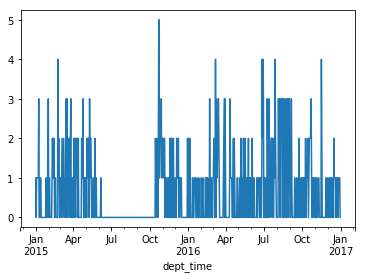

In [69]:
test2.plot()
plt.show()

<h3 style='color:green'>2.n번째 자전거는 매일 used_time의 평균이 어떻게 변했을까? </h3>

In [70]:
test2 = test.usedtime_hour.resample('D').mean()

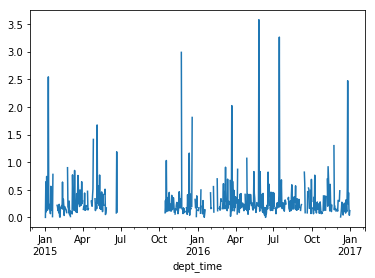

In [71]:
test2.plot()
plt.show()

<h3 style='color:green'>2-1.n번째 자전거는 매일 used_time의 moving average가 어떻게 변했을까? </h3>

In [74]:
test2 = test2.rolling(window=5).mean()

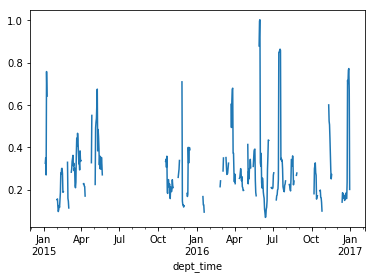

In [75]:
test2.plot()
plt.show()

<h3>각각의 터미널 별로 다시 groupby 하여 위와 같이 일별로 얼마나 새로 자전거가 들어왔는지도 볼 수 있음.</h3>

단, 여기서 첫 줄발지를 .iloc[1:] 해서 빼주지 않았으므로 첫 시작은 무조건 moved에 True 들어감. (minor하다고 생각함.)


원래 test.iloc[1:][test.moved==True] 이런식으로 해줘야 함. 

<h3 style='color:green'>3.n번째 터미널에는 매일 자전거가 얼마나 유입되었는가? - 인기가 많은 출발지인지 알 수 있음. </h3>

In [76]:
# 다 합친 것. 

df = pd.concat(bike_groups)

In [79]:
# 지희가 df 달라고 해서 여기서 뽑아 줌. 

df.to_pickle("bikes_all.p")

In [45]:
df = df[df.moved==True]

In [47]:
terminals = df.groupby("dept_terminal")

In [49]:
terminal_groups = [terminals.get_group(x) for x in terminals.groups]

In [59]:
test = terminal_groups[1].copy(deep=True)

In [60]:
test.index = test.dept_time

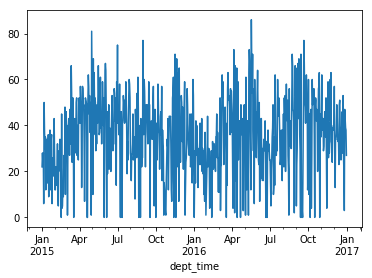

In [61]:
test2 = test.moved.resample('D').sum()
test2.plot()
plt.show()

In [291]:
test = df.head(10).copy(deep=True)

In [36]:
#실수해서 datetime --> string으로 다시 바꿔야 할 때 코드. 

for i in ['dept_time', 'arr_time']:
    df[i] = df[i].apply(lambda x: x.strftime("%y%m%d"))

In [41]:
# 실수해서 str타입 변수 뒤에 붙은거 뜯어낼 때 쓰는 코드. 

df["dept_time"] = df['dept_time'].map(lambda x: x.rstrip('dept_time'))
df['arr_time'] = df['arr_time'].map(lambda x: x.rstrip('arr_time'))